# Companion code to the paper: Incorporating Data-Driven Priors in the Maximum Entropy on the Mean Method for Linear Inverse Problems

This notebook serves as a companion to reproduce and further experiment with MEM denoising and deblurring with the MNIST dataset(s)

## Importing and vectorization of data, importing of basic packages

The data is normalized for numerical convenience. One may interchange MNIST and MNIST fashion for all the following numerics with no issue. 

In [1]:
# Importing of dataset(s)

from keras.datasets import mnist
(data, labels), (_, _) = mnist.load_data()
data = data/255;

#from keras.datasets import fashion_mnist
#(data, labels), (_, _) = fashion_mnist.load_data()
#data = data/255

# Basic Packages
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from scipy import linalg
from scipy import optimize

# Vectorization of data.
vec_data = np.zeros([np.shape(data)[0],28**2])

for i in range(np.shape(data)[0]):
    vec_data[i,:] = (data[i,:,:]).flatten();

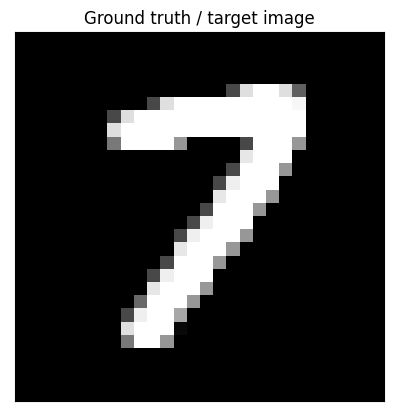

In [2]:
# One can specify an image using a filepath here
input_img  = plt.imread('C:/Users/mking/scripts/Research/MEMM_Codebase/handdrawn_images/handdrawn_7.png')

# Preprocessing may be necessary depending on the users' initial filetype.
# MNIST expects 28x28 greyscale pixel images, here we have normalized between 0-1

input_img = input_img[:,:,0]
img = -input_img+1
img[img<0]=0
img[img>1] = 1

# Or, one may specify an image from the dataset as the target image. 
# Make sure to delete this image from the dataset if so.

#img = vec_data[8].copy()
#vec_data[8] = np.zeros_like(b)

plt.figure()
plt.imshow(img.reshape(28,28),cmap = 'gray')
plt.yticks([]);
plt.xticks([]);
plt.title('Ground truth / target image');


# Definitions of common functions

In this code block, we define the emprirical moment generating function, log moment generating function, and its gradient.

These are computed in the most direct (and naive!) way. This can be done in more <a href="https://github.com/baggepinnen/MonteCarloMeasurements.jl/blob/4f9b688d298157dc24a5b0a518d971221fbe15dd/src/resampling.jl#L10">stable fashion</a>, but is deferred for future work.

In [3]:
def MGF(theta,data_slice):
    res = 0
    if(np.ndim(data_slice) > 1):
        n = np.size(data_slice[:,0])
        for i in range(n):
            res = res + (1/n)*np.exp(np.dot(theta,data_slice[i,:]))
    else:
        n = np.size(data_slice)
        for i in range(n):
           res = res + (1/n)*np.exp(np.dot(theta,data_slice[i]))
        
    return res

def LogMGF_deriv(theta,data_slice):
    denom = MGF(theta,data_slice)
    num = 0
    # expects a d by N matrix
    #d = size of data 
    # N = num data pints
    if(np.ndim(data_slice) > 1):
        n = np.size(data_slice[:,0])
        for i in range(n):
            num = num + data_slice[i,:]*(1/n)*np.exp(np.dot(theta,data_slice[i,:]))

    else:
        n = np.size(data_slice)
        for i in range(n):
            num = num + data_slice[i]*(1/n)*np.exp(np.dot(theta,data_slice[i]))
        
    return num/denom

def LogMGF(theta,data_slice):
    res = 0
    if(np.ndim(data_slice) > 1):
        n = np.size(data_slice[:,0])
        for i in range(n):
            res = res + (1/n)*np.exp(np.dot(theta,data_slice[i,:]))
    else:
        n = np.size(data_slice)
        for i in range(n):
           res = res + (1/n)*np.exp(np.dot(theta,data_slice[i]))
        
    return np.log(res)


def dnu(x,optimal_point,denom):
    # need to precompute denom for speed
    return np.exp(np.dot(optimal_point,x))/denom

# Experiments

Create noisy images, and show the output (observed) image

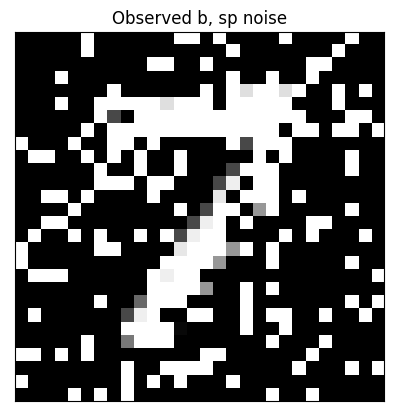

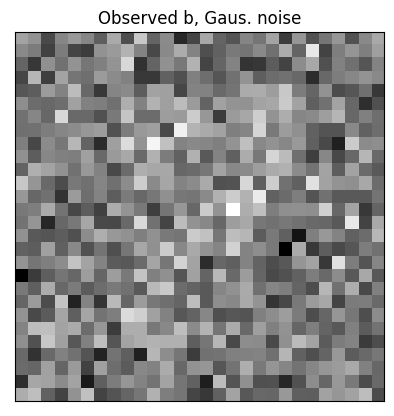

In [4]:
rng = np.random.default_rng()

# Target image, vectorized
x_true = img.flatten()

# observed b, vectorized. Here just additive noise
b_gauss = x_true.copy()
norm = np.linalg.norm(b_gauss)
b_gauss = b_gauss + np.random.normal(0,0.1*norm,784)


b_sp = x_true.copy()
#Salt-and-pepper corruption noise
for i in np.arange(np.size(b_sp)):
    random_unif = rd.uniform(0,1)
    if(random_unif < 0.2):
        b_sp[i]=0
    if(random_unif > 0.8):
        b_sp[i]=1


plt.figure()
plt.imshow(b_sp.reshape(28,28),cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title('Observed b, sp noise');

plt.figure()
plt.imshow(b_gauss.reshape(28,28),cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title('Observed b, Gaus. noise');

## Nearest neighbour from dataset.

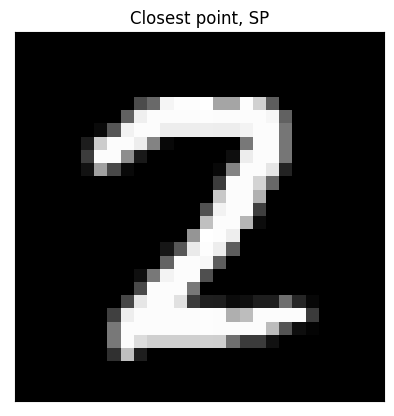

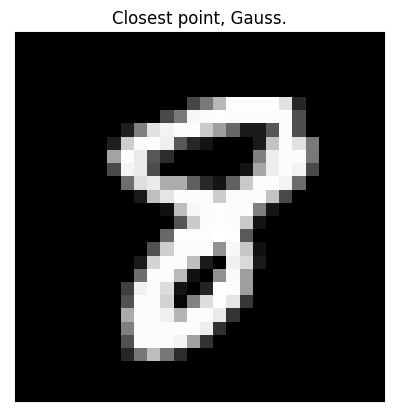

In [5]:
final_index_sp = 0; final_index_gauss = 0;
current_norm_sp = np.inf; current_norm_gauss = np.inf;

closest_img_sp = np.zeros_like(b_sp)
closest_img_gauss = np.zeros_like(b_gauss)

for i in np.arange(60000):
    
    current_candidate = vec_data[i]
    
    if(np.linalg.norm(b_gauss-current_candidate) <= current_norm_gauss):
        closest_img_gauss = vec_data[i]
        current_norm_gauss = np.linalg.norm(b_gauss-current_candidate)
        final_index_gauss =i
        
    if(np.linalg.norm(b_sp-current_candidate) <= current_norm_sp):
        closest_img_sp = vec_data[i]
        current_norm_sp = np.linalg.norm(b_sp-current_candidate)
        final_index_sp =i
            
plt.figure()
plt.imshow(closest_img_sp.reshape((28,28)),cmap = 'gray')
plt.yticks([])
plt.xticks([])
plt.title('Closest point, SP');

         
plt.figure()
plt.imshow(closest_img_gauss.reshape((28,28)),cmap = 'gray')
plt.yticks([])
plt.xticks([])
plt.title('Closest point, Gauss.');

## User Specified Test Parameters:

For several values of $n$, we drawn a random data sample of size $n$ num_test times, and perform MEM denoising for each.
See section $6$ of the associated paper for details on the experimental setup. The parameters following can be altered by the user at will to perform new experiments.

num_data_learned : specifies the values of $n$ to perform denoising 

num test : specifies the number of tests 

alphas : weighting parameter between fidelity and regularization terms.

b : choose b_gauss or b_sp



In [9]:
num_data_learned = np.linspace(10000,60000,20).astype(int)
num_test = 10
alphas = [2]
b = b_sp

## Experiment:


Note that if one simply wishes to see visual recovery, the computation of the full-data MEM solution for error bounds is not needed, and can be omitted to save computational time. 

This uses basic L-BFGS-B "black box" from python optimize. For larger scale experiments, one should use specialized optimization routines, which is an area of ongoing research.

Success for n=10000 and alpha = 2 over 10 tests.
Success for n=12631 and alpha = 2 over 10 tests.
Success for n=15263 and alpha = 2 over 10 tests.
Success for n=17894 and alpha = 2 over 10 tests.
Success for n=20526 and alpha = 2 over 10 tests.
Success for n=23157 and alpha = 2 over 10 tests.
Success for n=25789 and alpha = 2 over 10 tests.
Success for n=28421 and alpha = 2 over 10 tests.
Success for n=31052 and alpha = 2 over 10 tests.
Success for n=33684 and alpha = 2 over 10 tests.
Success for n=36315 and alpha = 2 over 10 tests.
Success for n=38947 and alpha = 2 over 10 tests.
Success for n=41578 and alpha = 2 over 10 tests.
Success for n=44210 and alpha = 2 over 10 tests.
Success for n=46842 and alpha = 2 over 10 tests.
Success for n=49473 and alpha = 2 over 10 tests.
Success for n=52105 and alpha = 2 over 10 tests.
Success for n=54736 and alpha = 2 over 10 tests.
Success for n=57368 and alpha = 2 over 10 tests.
Success for n=60000 and alpha = 2 over 10 tests.


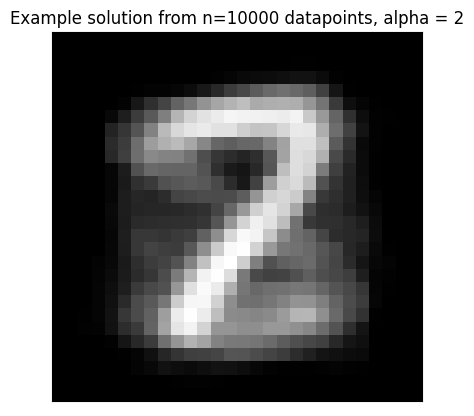

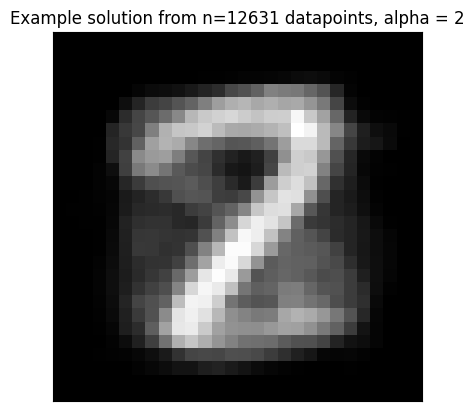

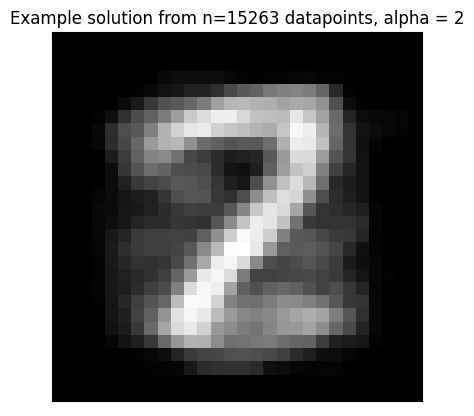

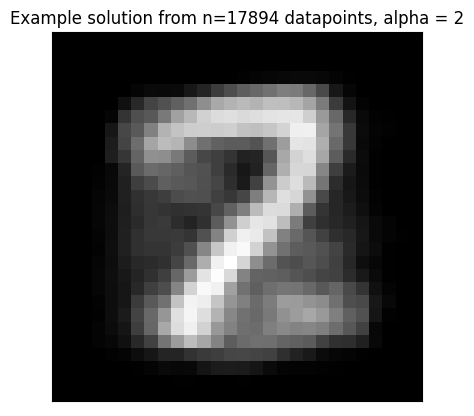

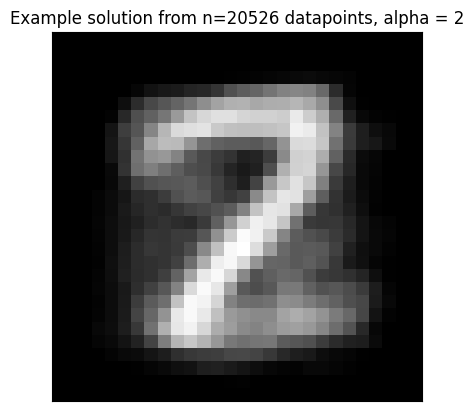

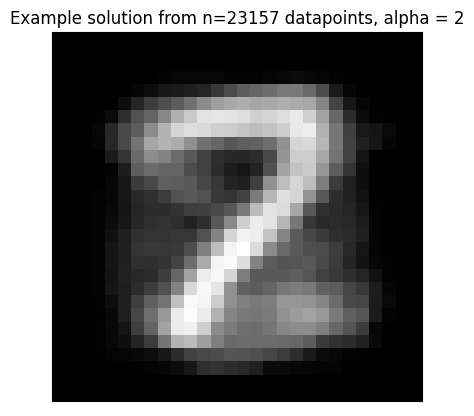

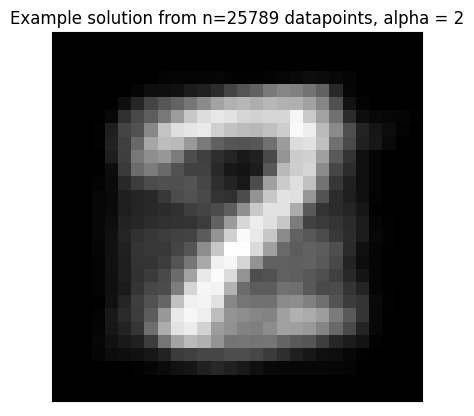

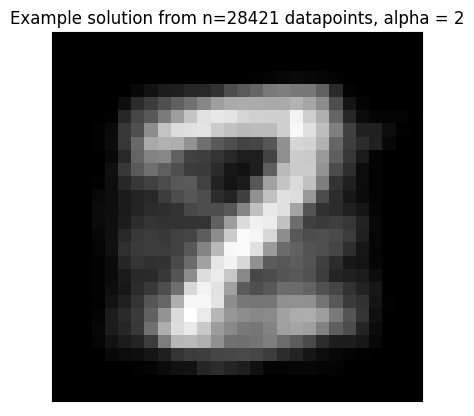

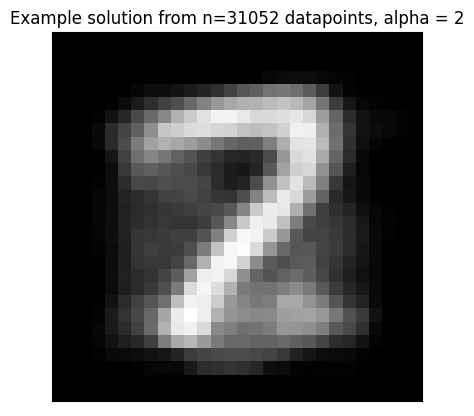

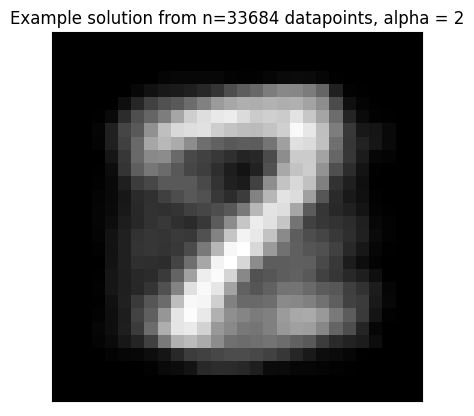

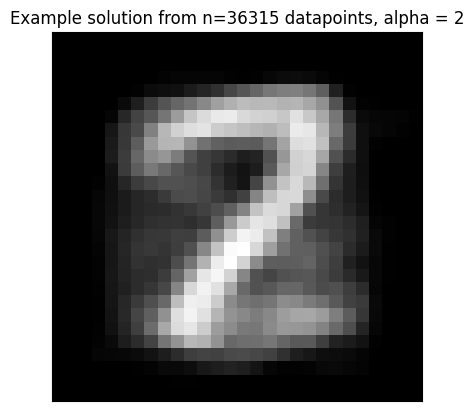

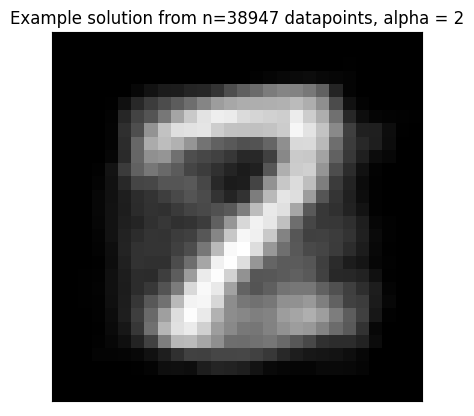

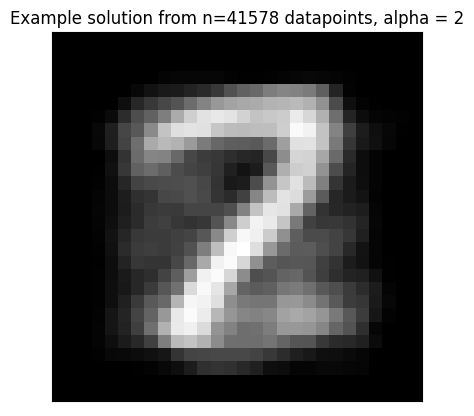

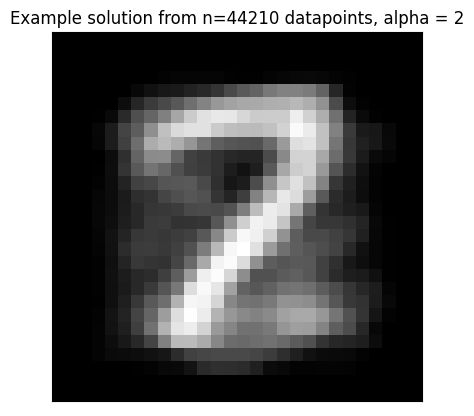

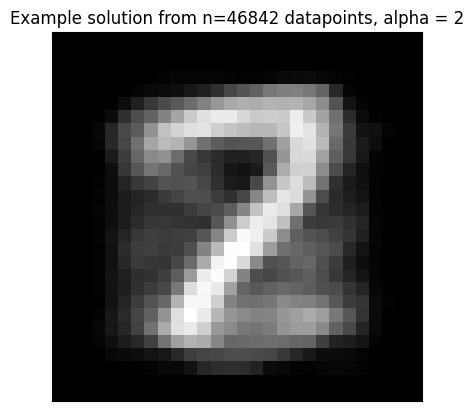

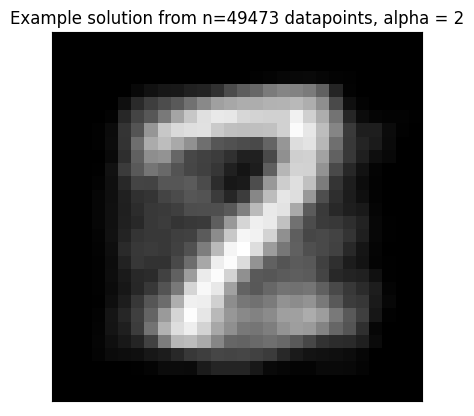

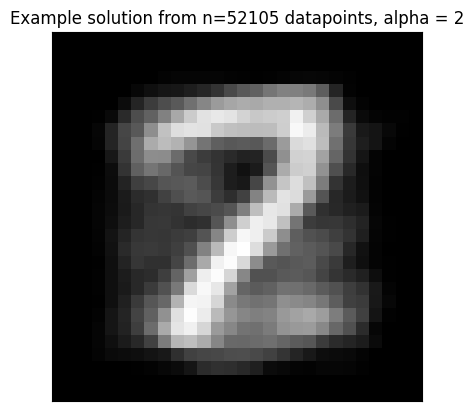

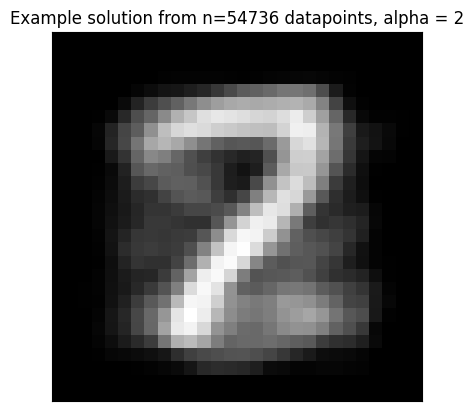

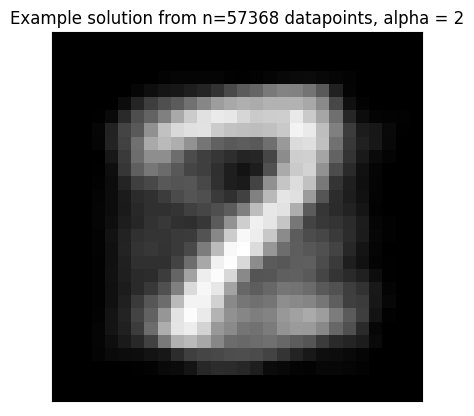

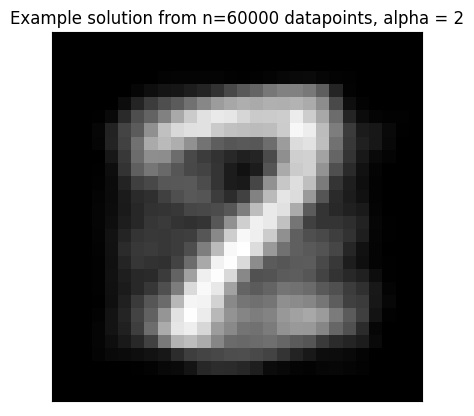

In [10]:
error = np.zeros([np.size(num_data_learned),np.size(alphas)])
x_target = np.ones_like(b)

rng = np.random.default_rng()

example_output_images = np.zeros([np.size(num_data_learned),np.size(alphas),np.size(b)])

for index_alpha,alpha in enumerate(alphas):

    # Finding target MEM reconstruction, using all the data. 
    # If one simply wishes to see visual reconstructions and not full error recovery, this is not needed.

    y_init = np.random.normal(0,1/256,28**2)
    func = lambda q: -np.dot(b,q) + (0.5)*(1/alpha)*np.linalg.norm(q)**2 + LogMGF(q,vec_data);
    grad = lambda q: -b + (1/alpha)*q +LogMGF_deriv(q,vec_data);

    result_opt = optimize.minimize(func,y_init, method='L-BFGS-B',jac = grad)

    x_target = LogMGF_deriv((result_opt.x),vec_data)
    
    for index_data,num_data in enumerate(num_data_learned):
        
        for current_test in np.arange(num_test):

            # Randomly sample num_data datapoints
            indices = np.random.choice(vec_data.shape[0], num_data, replace=False)
            data_slice = vec_data[indices]

            # Compute solution to the dual problem
            y_init = np.random.normal(0,1/256,28**2)
            func = lambda q: -np.dot(b,q) + (0.5)*(1/alpha)*np.linalg.norm(q)**2 + LogMGF(q,data_slice);
            grad = lambda q: -b + (1/alpha)*q +LogMGF_deriv(q,data_slice);

            result_opt = optimize.minimize(func,y_init, method='L-BFGS-B',jac = grad)

            # Corresponding primal Solution
            x_final = LogMGF_deriv(result_opt.x,data_slice)

            error[index_data,index_alpha] = error[index_data,index_alpha] + np.linalg.norm(x_final - x_target)/np.linalg.norm(x_target);
              
        error[index_data,index_alpha] =  error[index_data,index_alpha]/num_test
        example_output_images[index_data,index_alpha,:] = x_final
   
        # PLot visually recovered image for given num_data (for one test)
        print('Success for n=' + str(num_data) + ' and alpha = ' + str(alpha) +' over ' + str(num_test) + " tests.")
        
        plt.figure()
        plt.imshow(x_final.reshape((28,28)),cmap = 'gray')
        plt.yticks([])
        plt.xticks([])
        plt.title('Example solution from n=' + str(num_data) + ' datapoints, alpha = ' + str(alpha))

## Plots of Error:

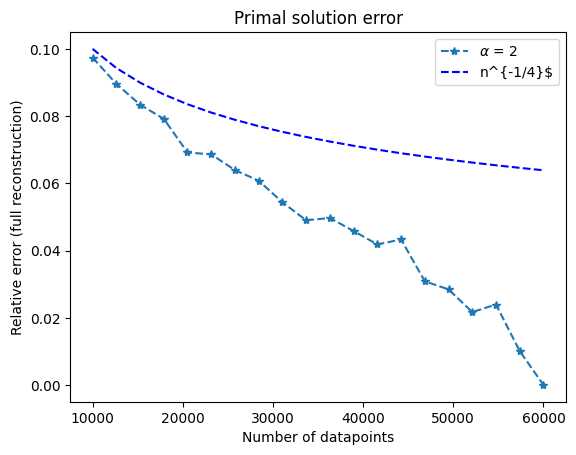

In [16]:
plt.title('Primal solution error');
plot_var =1*(np.power(num_data_learned,-1/4))
plt.xlabel('Number of datapoints');
plt.ylabel('Relative error (full reconstruction)');
for i in np.arange(np.size(alphas)):
    plt.plot(num_data_learned,error[:,i],'*--', label = r'$\alpha$ = ' + str(alphas[i]));
    
plt.plot(num_data_learned,plot_var,'b--', label = 'n^{-1/4}$');
plt.legend();

## Post-processing: Linear combination coefficients & pixel-wise masking

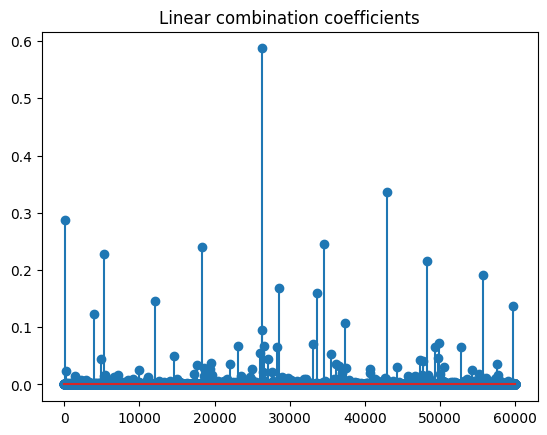

In [12]:
denom = MGF(result_opt.x,data_slice)
rho_n = np.zeros(num_data_learned[-1])

for index, current_img in enumerate(data_slice):
    rho_n[index] = dnu(current_img,result_opt.x,denom)
    rho_n[index] = rho_n[index]/num_data_learned[-1]

# optimal rho_n should always be a probability measure. 
# Numerical rounding may occur, so renormalize as a sanity check.
rho_n = rho_n/np.linalg.norm(rho_n)

plt.stem(rho_n);

plt.title("Linear combination coefficients");

(80,)


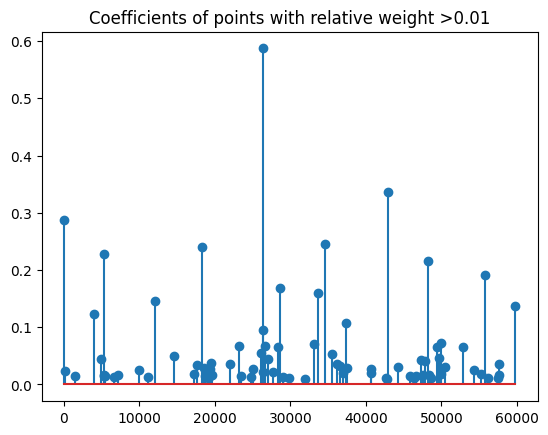

In [13]:
rho_n_cutoff = [];
indices_cutoff = [];
index_mask = 10e-3

for index, value in enumerate(rho_n):
    if(value > index_mask):
        rho_n_cutoff.append(value)
        indices_cutoff.append(index)
        
plt.title('Coefficients of points with relative weight >' + str(index_mask))
        
plt.stem(indices_cutoff,rho_n_cutoff);      

print(np.shape(rho_n_cutoff))

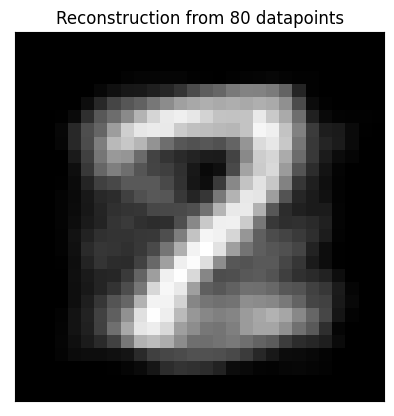

In [14]:
recon_cutoff = np.zeros_like(b)
for i in indices_cutoff:
    recon_cutoff = recon_cutoff + rho_n[i]*data_slice[i,:]
    
recon_cutoff = recon_cutoff/max(recon_cutoff)
    
plt.imshow(recon_cutoff.reshape(28,28), cmap = 'gray');
plt.xticks([]);
plt.yticks([]);
plt.title('Reconstruction from ' + str(np.shape(rho_n_cutoff)[0]) + ' datapoints');

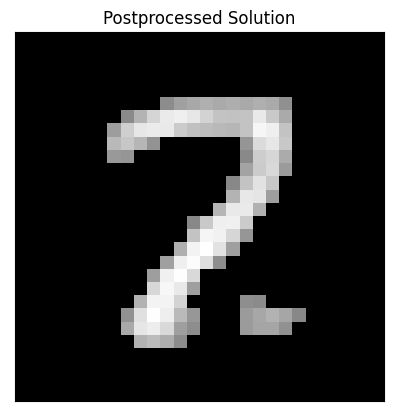

In [15]:
mask = 0.53

cutoff_v2 = recon_cutoff.copy()

cutoff_v2[recon_cutoff <= mask] = 0
#cutoff_v2[recon_cutoff >= 1-mask] = 1

plt.imshow(cutoff_v2.reshape(28,28), cmap = 'gray');
plt.xticks([])
plt.yticks([])
plt.title('Postprocessed Solution');

## 